TODO:
* get rid of [-1, 2], make all final action positive
* in policy, do softmax, scale to [-1, 1], then in env scale back (already done)
* add profit rewards back in; hp tune?
* get rid of features=0 requirement (linear model?)

investigate size (should be 17, not 17*85 ??)

gives /0 error for some reason?

also how is this not literally equiv to impossible??

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
import stable_baselines3
from portfolio_env_framework import *
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy.typing as npt
import gymnasium as gym

In [2]:
class TrainDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
        sec_df = pd.read_csv('sec_sentiment.csv', dtype='string')
    
        # convert datatypes for CRSP data
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)

        # clean sentiment data
        del sec_df['Unnamed: 0']
        sec_df['fdate'] = pd.to_datetime(sec_df['fdate'])
        sec_df.Sentiment = sec_df.Sentiment.astype(float)
        sec_df.lm_negative = sec_df.lm_negative.astype(float)
        sec_df.lm_positive = sec_df.lm_positive.astype(float)
        sec_df.lm_uncertainty = sec_df.lm_uncertainty.astype(float)
        sec_df.lm_negative = sec_df.groupby('TICKERH')['lm_negative'].transform(lambda v: v.ffill())
        sec_df.lm_positive = sec_df.groupby('TICKERH')['lm_positive'].transform(lambda v: v.ffill())
        sec_df.lm_uncertainty = sec_df.groupby('TICKERH')['lm_uncertainty'].transform(lambda v: v.ffill())

        # fill in missing dates for sentiment
        date_range = pd.date_range(sec_df.fdate.min(), sec_df.fdate.max(), freq='D')
        full_df = pd.DataFrame({'fdate': list(date_range)}).merge(pd.DataFrame({'TICKERH': list(sec_df.TICKERH.unique())}), how='cross')
        full_df['neg'] = np.nan
        full_df['pos'] = np.nan
        full_df['unc'] = np.nan
        for ticker in sec_df.TICKERH.unique():
            ticker_df = sec_df[sec_df.TICKERH == ticker]
            ticker_df.index = pd.DatetimeIndex(ticker_df.fdate)
            ticker_df = ticker_df.reindex(date_range, fill_value=np.nan)
            full_df.loc[full_df.TICKERH == ticker, 'neg'] = ticker_df.lm_negative.ffill().values
            full_df.loc[full_df.TICKERH == ticker, 'pos'] = ticker_df.lm_positive.ffill().values
            full_df.loc[full_df.TICKERH == ticker, 'unc'] = ticker_df.lm_uncertainty.ffill().values
    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        full_df = full_df[full_df.apply(lambda row: (row.TICKERH in self.tickers), axis=1)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        
        # create pivot tables
        self.neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
        self.pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
        self.unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = np.zeros((6, self.universe_size, 10))
        s[0, :, :] = self.stock_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[1, :, :] = self.high_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[2, :, :] = self.low_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[3, :, :] = self.neg_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[4, :, :] = self.pos_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[5, :, :] = self.unc_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [3]:
class DifferentialSharpeRatioReward(AbstractRewardManager):
    def __init__(self, eta: float = 1/252):
        self.eta = eta
        self.initialize_reward()

    def initialize_reward(self):
        self.A, self.B = 0.0, 0.0

    def compute_reward(self, old_port_val: float, new_port_val: float) -> float:
        R = np.log(new_port_val / old_port_val)
        dA = R - self.A
        dB = R ** 2 - self.B
        if self.B - self.A ** 2 == 0:
            D = 0
        else:
            D = (self.B * dA - 0.5 * self.A * dB) / (self.B - self.A ** 2) ** (3 / 2)
        self.A += self.eta * dA
        self.B += self.eta * dB
        return D

In [4]:
class ProfitReward(AbstractRewardManager):
    def __init__(self):
        pass

    def initialize_reward(self):
        pass

    def compute_reward(self, old_port_val: float, new_port_val: float) -> float:
        return new_port_val - old_port_val

In [5]:
class TestDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
        sec_df = pd.read_csv('sec_sentiment.csv', dtype='string')
    
        # convert datatypes for CRSP data
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)

        # clean sentiment data
        del sec_df['Unnamed: 0']
        sec_df['fdate'] = pd.to_datetime(sec_df['fdate'])
        sec_df.Sentiment = sec_df.Sentiment.astype(float)
        sec_df.lm_negative = sec_df.lm_negative.astype(float)
        sec_df.lm_positive = sec_df.lm_positive.astype(float)
        sec_df.lm_uncertainty = sec_df.lm_uncertainty.astype(float)
        sec_df.lm_negative = sec_df.groupby('TICKERH')['lm_negative'].transform(lambda v: v.ffill())
        sec_df.lm_positive = sec_df.groupby('TICKERH')['lm_positive'].transform(lambda v: v.ffill())
        sec_df.lm_uncertainty = sec_df.groupby('TICKERH')['lm_uncertainty'].transform(lambda v: v.ffill())

        # fill in missing dates for sentiment
        date_range = pd.date_range(sec_df.fdate.min(), sec_df.fdate.max(), freq='D')
        full_df = pd.DataFrame({'fdate': list(date_range)}).merge(pd.DataFrame({'TICKERH': list(sec_df.TICKERH.unique())}), how='cross')
        full_df['neg'] = np.nan
        full_df['pos'] = np.nan
        full_df['unc'] = np.nan
        for ticker in sec_df.TICKERH.unique():
            ticker_df = sec_df[sec_df.TICKERH == ticker]
            ticker_df.index = pd.DatetimeIndex(ticker_df.fdate)
            ticker_df = ticker_df.reindex(date_range, fill_value=np.nan)
            full_df.loc[full_df.TICKERH == ticker, 'neg'] = ticker_df.lm_negative.ffill().values
            full_df.loc[full_df.TICKERH == ticker, 'pos'] = ticker_df.lm_positive.ffill().values
            full_df.loc[full_df.TICKERH == ticker, 'unc'] = ticker_df.lm_uncertainty.ffill().values
    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        full_df = full_df[full_df.apply(lambda row: (row.TICKERH in self.tickers), axis=1)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        
        # create pivot tables
        self.neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
        self.pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
        self.unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)

        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = np.zeros((6, self.universe_size, 10))
        s[0, :, :] = self.stock_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[1, :, :] = self.high_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[2, :, :] = self.low_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[3, :, :] = self.neg_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[4, :, :] = self.pos_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[5, :, :] = self.unc_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [6]:
# class TestDataManager(AbstractDataManager):
#     def get_obs_space(self) -> gym.spaces.Box:
#         return gym.spaces.Dict({
#             'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6, self.universe_size, 10), dtype=np.float32),
#             'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
#         })

#     def get_data(self) -> tuple[int, int]:
#         # read SNP data
#         df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
#         # convert datatypes
#         df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
#         df.date = pd.to_datetime(df.date)
#         df.FACPR = df.FACPR.fillna('0.0')
#         df.astype({
#             'PRC': float,
#             'VOL': float,
#             'ASKHI': float,
#             'BIDLO': float,
#             'FACPR': float
#         })
    
#         # drop duplicates and nans
#         df = df.drop_duplicates(subset=['date', 'TICKER'])
#         df.dropna(inplace=True)
    
#         # only include stocks that are present in all dates
#         ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
#         def is_max_val_count(ticker: str) -> bool:
#           return ticker_ok[ticker] and ticker not in ['GOOG', 'EXC']
#         ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
#         df = df[ok]
#         df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
#         # create stock array
#         self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
#         self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
#         self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
#         # adjust for stock splits
#         facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
#         self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
#         self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
#         self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
#         self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
#         # get times and tickers
#         self.times = df.date.unique()[1:]
#         self.tickers = df.TICKER.unique()

#         # read and clean sentiment data
#         sec_df = pd.read_csv('sec_sentiment.csv', dtype='string')
#         del sec_df['Unnamed: 0']
#         sec_df['fdate'] = pd.to_datetime(sec_df['fdate'])
#         sec_df.Sentiment = sec_df.Sentiment.astype(float)
#         sec_df.lm_negative = sec_df.lm_negative.astype(float)
#         sec_df.lm_positive = sec_df.lm_positive.astype(float)
#         sec_df.lm_uncertainty = sec_df.lm_uncertainty.astype(float)
#         sec_df = sec_df[sec_df.TICKERH.isin(self.tickers)]
#         sec_df.lm_negative = sec_df.groupby('TICKERH')['lm_negative'].transform(lambda v: v.ffill())
#         sec_df.lm_positive = sec_df.groupby('TICKERH')['lm_positive'].transform(lambda v: v.ffill())
#         sec_df.lm_uncertainty = sec_df.groupby('TICKERH')['lm_uncertainty'].transform(lambda v: v.ffill())

#         # fill in missing dates
#         date_range = pd.date_range(sec_df.fdate.min(), sec_df.fdate.max(), freq='D')
#         full_df = pd.DataFrame({'fdate': list(date_range)}).merge(pd.DataFrame({'TICKERH': list(sec_df.TICKERH.unique())}), how='cross')
#         full_df['neg'] = np.nan
#         full_df['pos'] = np.nan
#         full_df['unc'] = np.nan
#         for ticker in sec_df.TICKERH.unique():
#             ticker_df = sec_df[sec_df.TICKERH == ticker]
#             ticker_df.index = pd.DatetimeIndex(ticker_df.fdate)
#             ticker_df = ticker_df.reindex(date_range, fill_value=np.nan)
#             full_df.loc[full_df.TICKERH == ticker, 'neg'] = ticker_df.lm_negative.ffill().values
#             full_df.loc[full_df.TICKERH == ticker, 'pos'] = ticker_df.lm_positive.ffill().values
#             full_df.loc[full_df.TICKERH == ticker, 'unc'] = ticker_df.lm_uncertainty.ffill().values
        
#         # create pivot tables
#         self.neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
#         self.pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
#         self.unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)
        
#         # read index data and compute volatilities
#         idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
#           'DATE': 'string',
#           'vwretd': float
#         })
#         idx_df.DATE = pd.to_datetime(idx_df.DATE)
#         idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
#         idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
#         idx_df.set_index('DATE', inplace=True)
#         self.idx_df = idx_df

#         self.num_time_periods = len(self.times)-15-1
#         self.universe_size = len(self.tickers)
#         print(f"{self.universe_size=}")
#         return self.num_time_periods, self.universe_size
    
#     def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
#         # today is self.times[self.t+10]
#         s = np.zeros((6, self.universe_size, 10))
#         s[0, :, :] = self.stock_df.loc[self.times[t:t+10], :].to_numpy().T
#         s[1, :, :] = self.high_df.loc[self.times[t:t+10], :].to_numpy().T
#         s[2, :, :] = self.low_df.loc[self.times[t:t+10], :].to_numpy().T
#         s[3, :, :] = self.neg_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
#         s[4, :, :] = self.pos_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
#         s[5, :, :] = self.unc_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
#         return {'data': s, 'weights': w}

#     def get_prices(self, t: int) -> npt.NDArray[np.float64]:
#         # today is self.times[self.t+10]
#         return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [7]:
# class TestDataManager(AbstractDataManager):
#     def get_obs_space(self) -> gym.spaces.Box:
#         return gym.spaces.Dict({
#             'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3, self.universe_size, 10), dtype=np.float32),
#             'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
#         })

#     def get_data(self) -> tuple[int, int]:
#         # read SNP data
#         df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
#         # convert datatypes
#         df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
#         df.date = pd.to_datetime(df.date)
#         df.FACPR = df.FACPR.fillna('0.0')
#         df.astype({
#             'PRC': float,
#             'VOL': float,
#             'ASKHI': float,
#             'BIDLO': float,
#             'FACPR': float
#         })
    
#         # drop duplicates and nans
#         df = df.drop_duplicates(subset=['date', 'TICKER'])
#         df.dropna(inplace=True)
    
#         # only include stocks that are present in all dates
#         ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
#         def is_max_val_count(ticker: str) -> bool:
#           return ticker_ok[ticker]
#         ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
#         df = df[ok]
#         df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
#         # create stock array
#         self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
#         self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
#         self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
#         # adjust for stock splits
#         facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
#         self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
#         self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
#         self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
#         # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
#         self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
#         # get times and dickers
#         self.times = df.date.unique()[1:]
#         self.tickers = df.TICKER.unique()
        
#         self.num_time_periods = len(self.times)-15-1
#         self.universe_size = len(self.tickers)

#         # read index data and compute volatilities
#         idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
#           'DATE': 'string',
#           'vwretd': float
#         })
#         idx_df.DATE = pd.to_datetime(idx_df.DATE)
#         idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
#         idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
#         idx_df.set_index('DATE', inplace=True)
#         self.idx_df = idx_df

#         return self.num_time_periods, self.universe_size
    
#     def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
#         # today is self.times[self.t+10]
#         s = np.zeros((3, self.universe_size, 10))
#         s[0, :, :] = self.stock_df.loc[self.times[t:t+10], :].to_numpy().T
#         s[1, :, :] = self.high_df.loc[self.times[t:t+10], :].to_numpy().T
#         s[1, :, :] = self.low_df.loc[self.times[t:t+10], :].to_numpy().T
#         return {'data': s, 'weights': w}

#     def get_prices(self, t: int) -> npt.NDArray[np.float64]:
#         # today is self.times[self.t+10]
#         return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [14]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class Custom_EIEE_CNN_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 948):
        super(Custom_EIEE_CNN_Extractor, self).__init__(observation_space, features_dim)
        n_channels, self.universe_size, data_len = observation_space['data'].shape
        # self.cnn = nn.Sequential(
        #     nn.Conv1d(n_channels, 4, kernel_size=(3,)),
        #     # nn.ReLU(),
        #     # nn.Conv1d(5, 7, kernel_size=(3,)),
        #     # nn.ReLU(),
        #     # nn.Conv1d(7, 9, kernel_size=(3,)),
        #     # nn.ReLU(),
        #     # nn.Conv1d(9, 11, kernel_size=(data_len-6,)),
        # ).cuda()
        # self.cnn = nn.Conv1d(n_channels, 2, (data_len,)).cuda()
        # self.v_cnn = torch.vmap(self.cnn, in_dims=2, out_dims=2)
        # self.cnn = nn.Conv2d(n_channels, 4, (1, data_len)).cuda()
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 6, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(6, 8, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(8, 10, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(10, 12, kernel_size=(1, data_len-6)),
        ).cuda()

    def forward(self, observations: dict[str, torch.Tensor]) -> torch.Tensor:
        # print(f"{observations['data'].shape=}")
        x = self.cnn(observations['data'])
        return x.flatten(start_dim=1)
        # print(f"{observations['data'].shape=}")

        # x = observations['data'][:, :, :, 0]
        # print(f"{x.shape=}, {x=}")

        x = observations['data'][:, 0, :, 0]
        return x.flatten(start_dim=1)

        # print(f"{x.shape=}, {x.detach().cpu().numpy()=}")
        # print(f"{x[:, 0, :].detach().cpu().numpy()=}")
        w = observations['weights'][:, None, :]
        y = torch.cat((x.squeeze(-1), w), dim=1)
        # print(f"{y.detach().cpu().numpy()=}")
        # return y
        # return torch.ones_like(y).to(device=y.device, dtype=y.dtype)
        return y.flatten(start_dim=1)

In [9]:
# class Custom_EIEE_Network(nn.Module):
#     def __init__(self, observation_space: gym.spaces.Dict, input_features: int = 3, *args, **kwargs):
#         super(Custom_EIEE_Network, self).__init__(*args, **kwargs)
#         self.observation_space = observation_space
#         self.net = nn.Sequential(
#             nn.Linear(input_features, 1)
#         )
#         self.vec_net = torch.vmap(torch.vmap(self.net))

#     def forward(self, features: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
#         x = self.vec_net(torch.transpose(features, 1, 2)).squeeze(-1)
#         print(f"{x=}")
#         x_hat = 2 * nn.functional.softmax(5 * x, dim=1) - 1
#         return x_hat

In [10]:
# from stable_baselines3.td3.policies import Actor
# from stable_baselines3.common.policies import BaseModel
# from stable_baselines3.common.preprocessing import get_action_dim

# class CustomActor(Actor):
#     def __init__(self, observation_space: gym.spaces.Dict, *args, **kwargs):
#         super(CustomActor, self).__init__(observation_space, *args, **kwargs)
#         self.mu = Custom_EIEE_Network(observation_space)

# class DenseMlp(nn.Module):
#     def __init__(
#         self,
#         input_dim: int,
#         output_dim: int,
#         hidden_dim: int = 16,
#         n_layers: int = 2,
#         squash_output: bool = False,
#     ):
#         super(DenseMlp, self).__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.squash_output = squash_output
#         self.layer_1 = nn.Linear(input_dim, hidden_dim)
#         self.layer_2 = nn.Linear(hidden_dim + input_dim, hidden_dim)
#         if output_dim > 0:
#             self.output_layer = nn.Linear(hidden_dim + input_dim, output_dim)
#         self.output_activation = nn.Tanh()

#     def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
#         out_1 = F.relu(self.layer_1(input_tensor))
#         input_2 = torch.cat([out_1, input_tensor], dim=1)
#         out_2 = F.relu(self.layer_2(input_2))

#         if self.output_dim < 0:
#             return out_2

#         input_3 = torch.cat([out_2, input_tensor], dim=1)
#         out_3 = self.output_layer(input_3)

#         if self.squash_output:
#             out_3 = self.output_activation(out_3)
#         return out_3

# class DenseContinuousCritic(BaseModel):
#     def __init__(
#         self,
#         observation_space: gym.spaces.Space,
#         action_space: gym.spaces.Space,
#         net_arch: list[int],
#         features_extractor: nn.Module,
#         features_dim: int,
#         activation_fn: type[nn.Module] = nn.ReLU,
#         normalize_images: bool = True,
#         n_critics: int = 2,
#         share_features_extractor: bool = True,
#     ):
#         super().__init__(
#             observation_space,
#             action_space,
#             features_extractor=features_extractor,
#             normalize_images=normalize_images,
#         )

#         action_dim = get_action_dim(self.action_space)

#         self.share_features_extractor = share_features_extractor
#         self.n_critics = n_critics
#         self.q_networks = []
#         features_dim = 4 * 5 # TODO: bad idea
#         for idx in range(n_critics):
#             q_net = DenseMlp(features_dim, 1)
#             self.add_module(f"qf{idx}", q_net)
#             self.q_networks.append(q_net)

#     def forward(self, obs: torch.Tensor, actions: torch.Tensor) -> tuple[torch.Tensor, ...]:
#         # Learn the features extractor using the policy loss only
#         # when the features_extractor is shared with the actor
#         with torch.set_grad_enabled(not self.share_features_extractor):
#             features = self.extract_features(obs, self.features_extractor)
#         qvalue_input = torch.cat([features, actions[:, None, :]], dim=1).flatten(start_dim=1)
#         return tuple(q_net(qvalue_input) for q_net in self.q_networks)

#     def q1_forward(self, obs: torch.Tensor, actions: torch.Tensor) -> torch.Tensor:
#         """
#         Only predict the Q-value using the first network.
#         This allows to reduce computation when all the estimates are not needed
#         (e.g. when updating the policy in TD3).
#         """
#         with torch.no_grad():
#             features = self.extract_features(obs, self.features_extractor)
#         # print(f"features mean={features.mean().detach().cpu().numpy()}, std={features.std().detach().cpu().numpy()}")
#         # print(f"actions min={actions.detach().cpu().min()}, max={actions.detach().cpu().max()}, median={actions.median().detach().cpu().numpy()}, mean={actions.mean().detach().cpu().numpy()}, std={actions.std().detach().cpu().numpy()}")       
#         q1 = self.q_networks[0](torch.cat([features, actions[:, None, :]], dim=1).flatten(start_dim=1))
#         # print(f"q1 mean={q1.mean().detach().cpu().numpy()}, std={q1.std().detach().cpu().numpy()}")
#         return q1

In [11]:
# from typing import Optional
# from stable_baselines3.td3.policies import TD3Policy

# class CustomTD3Policy(TD3Policy):
#     def __init__(self, observation_space: gym.spaces.Dict, *args, **kwargs):
#         super(CustomTD3Policy, self).__init__(observation_space, *args, **kwargs)
#         self.observation_space = observation_space

#     def make_actor(self, features_extractor: Optional[BaseFeaturesExtractor] = None) -> CustomActor:
#         actor_kwargs = self._update_features_extractor(self.actor_kwargs, features_extractor)
#         return CustomActor(**actor_kwargs).to(self.device)

#     def make_critic(self, features_extractor: Optional[BaseFeaturesExtractor] = None) -> DenseContinuousCritic:
#         critic_kwargs = self._update_features_extractor(self.critic_kwargs, features_extractor)
#         return DenseContinuousCritic(**critic_kwargs).to(self.device)

In [35]:
# Parallel environments
from stable_baselines3 import DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise

train_env = PortfolioEnvWithTCost(dm=TrainDataManager(), rm=ProfitReward(), cp=0.01, cs=0.01)

# Set seeds
random.seed(42)
np.random.seed(42)
# train_env.seed(42)
train_env.action_space.seed(43)
torch.manual_seed(42)

# model = DDPG(CustomTD3Policy, train_env, buffer_size=250, verbose=1, policy_kwargs={
#   'features_extractor_class': Custom_EIEE_CNN_Extractor,
#   'net_arch': [16, 16],
#   'optimizer_class': torch.optim.AdamW
# })
# }, action_noise=NormalActionNoise(mean=np.zeros((85,)), sigma=0.1),)
model = DDPG('MultiInputPolicy', train_env, buffer_size=4*10**5, verbose=1, policy_kwargs={
  'features_extractor_class': Custom_EIEE_CNN_Extractor,
  # 'net_arch': [50, 50],
}, action_noise=NormalActionNoise(mean=0, sigma=0.02*np.ones(80)))
# }, action_noise=NormalActionNoise(mean=np.zeros((85,)), sigma=0.1),)
model.learn(total_timesteps=10**10, log_interval=1)
# model.save("cnn_portoflio_policy")

self.universe_size=79
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\sumit\GitRepos\portfolio-rl\venv\Lib\site-packages\stable_baselines3\common\buffers.py:605: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 15.56GB > 14.60GB
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5e+03  |
|    ep_rew_mean     | 0.416    |
| time/              |          |
|    episodes        | 1        |
|    fps             | 34       |
|    time_elapsed    | 72       |
|    total_timesteps | 2499     |
| train/             |          |
|    actor_loss      | 0.0485   |
|    critic_loss     | 5.35e-05 |
|    learning_rate   | 0.001    |
|    n_updates       | 2398     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5e+03  |
|    ep_rew_mean     | 1.07     |
| time/              |          |
|    episodes        | 2        |
|    fps             | 34       |
|    time_elapsed    | 146      |
|    total_timesteps | 4998     |
| train/             |          |
|    actor_loss      | 0.0299   |
|    critic_loss     | 5.68e-05 |
|    learning_rate   | 0.001    |
|    n_updates       | 4897     |
--------------

KeyboardInterrupt: 

In [36]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    # dm=TrainDataManager(),
    rm=ProfitReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)
# env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
#     'dm': TestDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.10/365,
#     'cs': 0.10/365
# })
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+15]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    # print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+15])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+15]].vwretd.values[0]))
    if terminated:
        break

self.universe_size=79


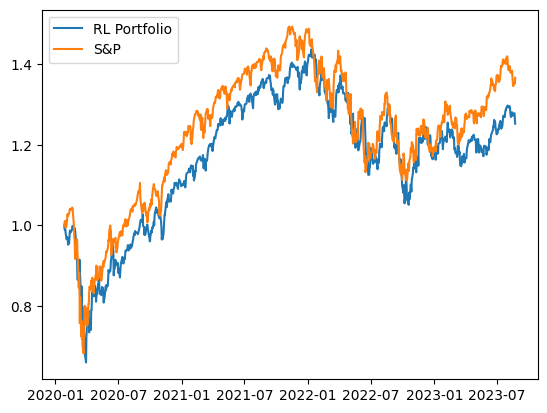

In [37]:
# actual sec, training 20m, std=0.01
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

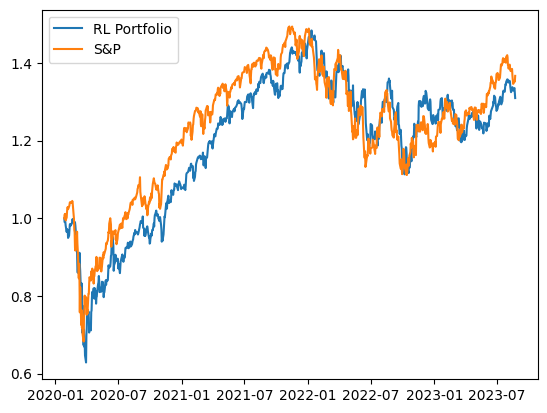

In [34]:
# actual sec, training 10m, std=0.02, slightly larger buffer
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

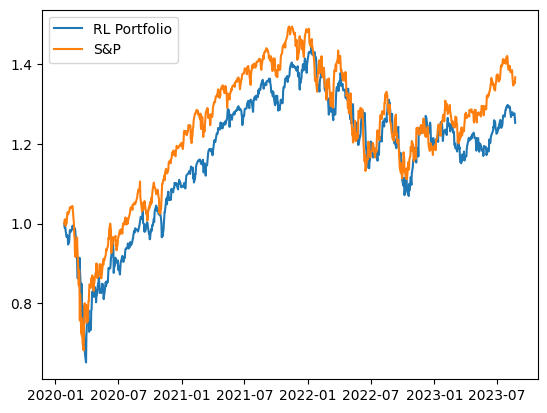

In [31]:
# actual sec, training 10m, std=0.03
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

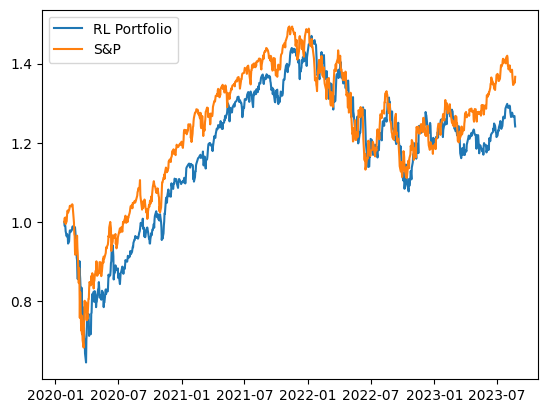

In [28]:
# actual sec, training 15m, std=0.05 (please work??)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

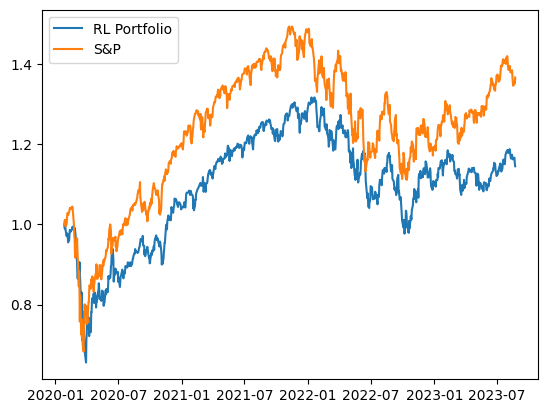

In [20]:
# actual sec, training 20m, std=0.1
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

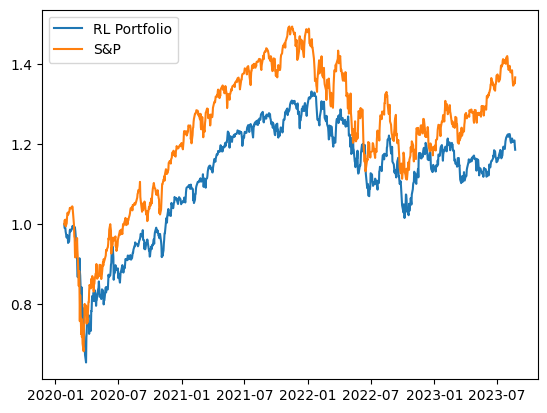

In [17]:
# actual sec, no training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

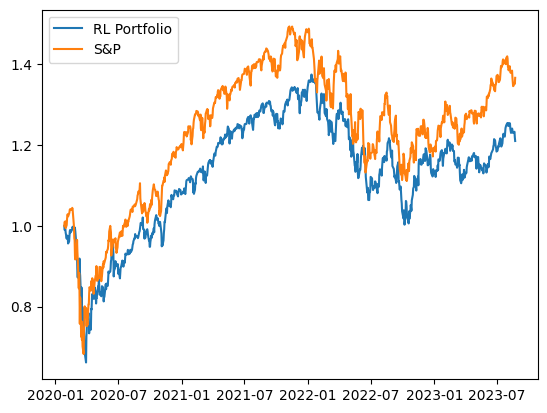

In [12]:
# sec, no training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

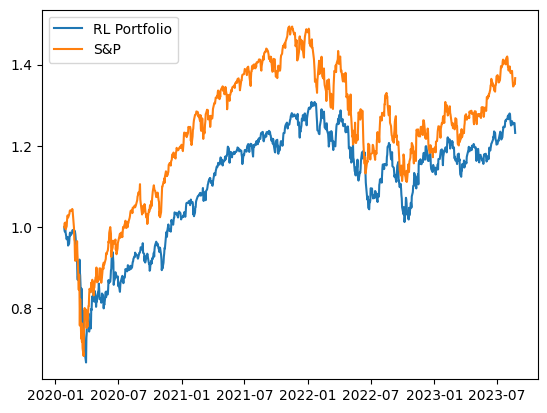

In [19]:
# basic, no training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

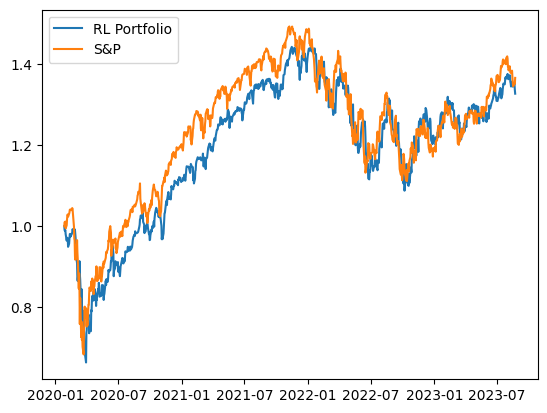

In [16]:
# basic, 15min training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [54]:
actions[0]

array([-1.,  1., -1., -1., -1.])

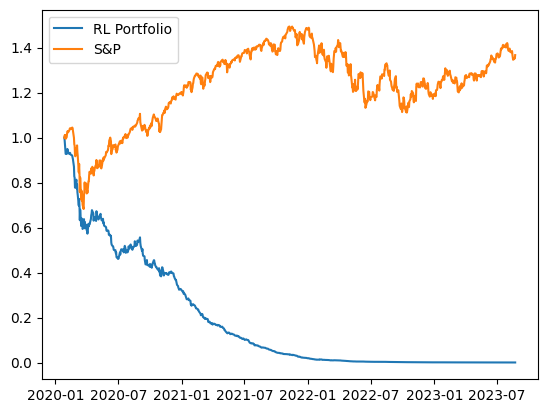

In [12]:
# basic
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

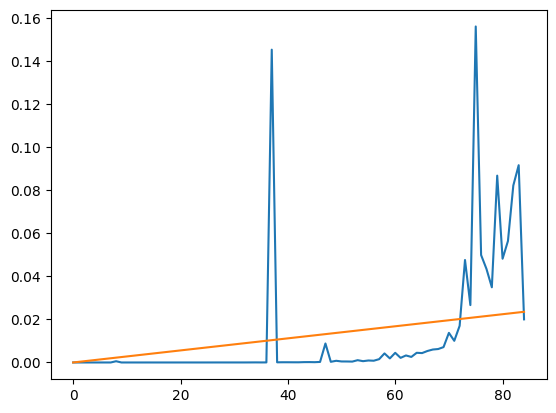

In [17]:
plt.plot((actions[0] + 1)/2)
plt.plot(np.linspace(0, 1, 85) / np.linspace(0, 1, 85).sum())
plt.show()